In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Sampler
import itertools
import os
from PIL import Image
from torchvision import transforms
import random
from collections import defaultdict


In [11]:
class PKSampler(Sampler):
    """
    PK Sampler for Person Re-ID: P persons × K images per person
    """
    def __init__(self, data_source, P=16, K=4):
        self.data_source = data_source
        self.P = P  # Number of persons per batch
        self.K = K  # Number of images per person
        
        # Group samples by person ID
        self.pid_to_indices = defaultdict(list)
        for idx, (_, pid) in enumerate(data_source.samples):
            self.pid_to_indices[pid].append(idx)
        
        # Filter out persons with less than K images
        self.valid_pids = [pid for pid, indices in self.pid_to_indices.items() 
                          if len(indices) >= self.K]
        
        if len(self.valid_pids) < self.P:
            raise ValueError(f"Not enough persons with at least {self.K} images. "
                           f"Found {len(self.valid_pids)}, need {self.P}")
    
    def __iter__(self):
        # Calculate number of batches
        num_batches = len(self.valid_pids) // self.P
        
        for _ in range(num_batches):
            # Randomly select P persons
            selected_pids = random.sample(self.valid_pids, self.P)
            
            batch_indices = []
            for pid in selected_pids:
                # Randomly select K images for this person
                available_indices = self.pid_to_indices[pid]
                selected_indices = random.sample(available_indices, 
                                               min(self.K, len(available_indices)))
                batch_indices.extend(selected_indices)
            
            # Shuffle within batch to avoid ordering bias
            random.shuffle(batch_indices)
            yield batch_indices
    
    def __len__(self):
        return len(self.valid_pids) // self.P

class PersonReIDTrainDataset(torch.utils.data.Dataset):
    """
    Dataset for training set: expects structure Dataset/train/<pid>/*.jpg
    Returns (image, label)
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # List of (img_path, label)
        self.label_map = {}  # pid (str) -> label (int)
        self._prepare()

    def _prepare(self):
        pids = sorted(os.listdir(self.root_dir))
        self.label_map = {pid: idx for idx, pid in enumerate(pids)}
        for pid in pids:
            pid_dir = os.path.join(self.root_dir, pid)
            if not os.path.isdir(pid_dir):
                continue
            for fname in os.listdir(pid_dir):
                if fname.lower().endswith('.jpg'):
                    self.samples.append((os.path.join(pid_dir, fname), self.label_map[pid]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

class PersonReIDTestDataset(torch.utils.data.Dataset):
    """
    Dataset for query/gallery set: expects structure Dataset/query/*.jpg or Dataset/gallery/*.jpg
    Returns (image, label, cam_id)
    """
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform
        self.samples = []  # List of (img_path, label, cam_id)
        self._prepare()

    def _prepare(self):
        for fname in os.listdir(self.dir_path):
            if fname.lower().endswith('.jpg'):
                # Example: 0001_c1s1_001051_00.jpg
                parts = fname.split('_')
                if len(parts) < 2:
                    continue
                label = int(parts[0])
                cam_id = int(parts[1][1])  # e.g., c1 -> 1
                self.samples.append((os.path.join(self.dir_path, fname), label, cam_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, cam_id = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label, cam_id


In [12]:
# =========================
# 3. Model Definition
# =========================
class PersonReIDModel(nn.Module):
    """
    Person Re-identification model with ResNet50 backbone
    """
    def __init__(self, num_classes, feature_dim=2048):
        super(PersonReIDModel, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn_neck = nn.BatchNorm1d(feature_dim)
        self.bn_neck.bias.requires_grad_(False)
        self.classifier = nn.Linear(feature_dim, num_classes, bias=False)
        self._init_params()
    def _init_params(self):
        nn.init.kaiming_normal_(self.classifier.weight, mode='fan_out')
        nn.init.constant_(self.bn_neck.weight, 1)
        nn.init.constant_(self.bn_neck.bias, 0)
    def forward(self, x):
        x = self.backbone(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        features = self.bn_neck(x)
        logits = self.classifier(features)
        return features, logits

In [13]:
class FIDILoss(nn.Module):
    """
    Fine-grained Difference-aware (FIDI) Pairwise Loss
    Corrected implementation following the paper exactly
    """
    def __init__(self, alpha=1.05, beta=0.5):
        super(FIDILoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = 1e-8
    
    def forward(self, features, labels):
        """
        Args:
            features: tensor of shape (batch_size, feature_dim)
            labels: tensor of shape (batch_size,)
        """
        # Compute pairwise distances
        distances = self.compute_pairwise_distances(features)
        
        # Compute ground truth binary relationship matrix K
        labels = labels.view(-1, 1)
        k_matrix = (labels == labels.T).float()  # 1 if same identity, 0 otherwise
        
        # Compute learned probability distribution U using exponential function
        u_matrix = torch.exp(-self.beta * distances)
        
        # Compute D(U||K) + D(K||U)
        d_u_k = self.compute_kl_divergence(u_matrix, k_matrix)
        d_k_u = self.compute_kl_divergence(k_matrix, u_matrix)
        
        total_loss = d_u_k + d_k_u
        
        return total_loss
    
    def compute_pairwise_distances(self, features):
        """Compute Euclidean distances between all pairs of features"""
        n = features.size(0)
        # Expand features to compute all pairwise distances
        features_1 = features.unsqueeze(1).expand(n, n, -1)
        features_2 = features.unsqueeze(0).expand(n, n, -1)
        
        # Compute Euclidean distance
        distances = torch.sqrt(torch.sum((features_1 - features_2) ** 2, dim=2) + self.eps)
        
        return distances
    
    def compute_kl_divergence(self, p_matrix, q_matrix):
        """
        Compute KL divergence D(P||Q) following Equation (5) from the paper:
        D(P||Q) = Σ p_ij * log(α * p_ij / ((α-1) * p_ij + q_ij))
        """
        # Clamp to avoid numerical issues
        p_matrix = torch.clamp(p_matrix, min=self.eps, max=1-self.eps)
        q_matrix = torch.clamp(q_matrix, min=self.eps, max=1-self.eps)
        
        # Compute the denominator: (α-1) * p_ij + q_ij
        denominator = (self.alpha - 1) * p_matrix + q_matrix
        denominator = torch.clamp(denominator, min=self.eps)
        
        # Compute the fraction: α * p_ij / denominator
        numerator = self.alpha * p_matrix
        fraction = numerator / denominator
        fraction = torch.clamp(fraction, min=self.eps)
        
        # Compute KL divergence: p_ij * log(fraction)
        kl_div = p_matrix * torch.log(fraction)
        
        # Exclude diagonal elements (self-comparisons) and compute mean
        mask = ~torch.eye(p_matrix.size(0), dtype=torch.bool, device=p_matrix.device)
        kl_div = kl_div[mask].mean()
        
        return kl_div

In [ ]:
# =========================
# 5. Trainer Class
# =========================
class FIDITrainer:
    """
    Improved Training framework for Person Re-ID with FIDI loss
    """
    def __init__(self, model, num_classes, device='cuda', 
                 alpha=1.05, beta=0.5, lr=3.5e-4, weight_decay=5e-4,
                 loss_strategy='adaptive'):
        # Multi-GPU support
        if isinstance(device, (list, tuple)):
            assert torch.cuda.is_available(), "CUDA must be available for multi-GPU."
            self.device = torch.device(f"cuda:{device[0]}")
            model = model.to(self.device)
            self.model = nn.DataParallel(model, device_ids=device)
        else:
            self.device = torch.device(device)
            self.model = model.to(self.device)
        
        self.num_classes = num_classes
        self.fidi_loss = FIDILoss(alpha=alpha, beta=beta)
        self.ce_loss = nn.CrossEntropyLoss()
        self.loss_strategy = loss_strategy
        
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr=lr, 
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=40, gamma=0.1
        )
        
        # For adaptive strategy
        self.loss_history = {'fidi': [], 'ce': []}
        self.best_mAP = 0.0
    
    def get_loss_weights(self, epoch, total_epochs, strategy=None):
        """
        Multiple loss weighting strategies based on training progress and loss magnitudes
        """
        if strategy is None:
            strategy = self.loss_strategy
            
        progress = epoch / total_epochs
        
        if strategy == 'conservative':
            # More conservative approach - slower FIDI ramp-up, maintain CE importance
            fidi_weight = min(0.8, progress * 1.5)  # Max 0.8, reaches it at 53% of training
            cls_weight = max(0.8, 1.2 - progress)   # Min 0.8, gradual decrease
            
        elif strategy == 'progressive':
            # Gradual transition with smooth curves
            import math
            fidi_weight = 0.5 * (1 + math.tanh(4 * (progress - 0.5)))  # Sigmoid-like curve
            cls_weight = 1.0 - 0.3 * progress  # Linear decrease to 0.7
            
        elif strategy == 'adaptive':
            # Adaptive based on loss magnitudes (requires loss history)
            if len(self.loss_history['fidi']) > 5:
                # Calculate recent loss ratios
                recent_fidi = sum(self.loss_history['fidi'][-5:]) / 5
                recent_ce = sum(self.loss_history['ce'][-5:]) / 5
                
                # Balance weights based on loss magnitudes
                if recent_fidi > recent_ce * 2:  # FIDI much larger
                    fidi_weight = max(0.3, min(0.7, 0.5 - 0.2 * (recent_fidi / recent_ce - 2)))
                    cls_weight = 1.0
                elif recent_ce > recent_fidi * 2:  # CE much larger
                    fidi_weight = min(1.0, 0.5 + 0.3 * (recent_ce / recent_fidi - 2))
                    cls_weight = max(0.7, 1.0 - 0.2 * (recent_ce / recent_fidi - 2))
                else:  # Balanced
                    fidi_weight = 0.5 + 0.3 * progress
                    cls_weight = 1.0 - 0.2 * progress
            else:
                # Early training fallback
                fidi_weight = 0.3 + 0.3 * progress
                cls_weight = 1.0
                
        elif strategy == 'fixed':
            # Simple fixed weights
            fidi_weight = 0.7
            cls_weight = 1.0
            
        else:  # 'original' - your current strategy
            fidi_weight = min(1.0, epoch / (total_epochs * 0.3))
            cls_weight = max(0.5, 1.0 - epoch / (total_epochs * 0.8))
        
        return fidi_weight, cls_weight
    
    def train_epoch(self, dataloader, epoch=0, total_epochs=120):
        self.model.train()
        total_loss = 0.0
        total_fidi_loss = 0.0
        total_ce_loss = 0.0
        batch_losses = []
        batch_fidi_losses = []
        batch_ce_losses = []
        
        # Get dynamic weights for this epoch
        fidi_weight, cls_weight = self.get_loss_weights(epoch, total_epochs)
        
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            features, logits = self.model(images)
            fidi_loss = self.fidi_loss(features, labels)
            ce_loss = self.ce_loss(logits, labels)
            
            # Apply dynamic weighting
            loss = fidi_weight * fidi_loss + cls_weight * ce_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            # Store all batch values
            batch_loss = loss.item()
            batch_fidi = fidi_loss.item()
            batch_ce = ce_loss.item()
            
            total_loss += batch_loss
            total_fidi_loss += batch_fidi
            total_ce_loss += batch_ce
            
            batch_losses.append(batch_loss)
            batch_fidi_losses.append(batch_fidi)
            batch_ce_losses.append(batch_ce)
            
            if batch_idx % 50 == 0:
                print(f'Batch {batch_idx}: Loss={batch_loss:.6f}, '
                      f'FIDI={batch_fidi:.6f}×{fidi_weight:.2f}, '
                      f'CE={batch_ce:.6f}×{cls_weight:.2f}')
        
        avg_loss = total_loss / len(dataloader)
        avg_fidi_loss = total_fidi_loss / len(dataloader)
        avg_ce_loss = total_ce_loss / len(dataloader)
        
        # Calculate additional statistics
        min_loss = min(batch_losses)
        max_loss = max(batch_losses)
        std_loss = np.std(batch_losses)
        
        print(f'Epoch Summary: Avg Loss={avg_loss:.6f}, Min={min_loss:.6f}, Max={max_loss:.6f}, Std={std_loss:.6f}')
        print(f'FIDI: Avg={avg_fidi_loss:.6f}, Min={min(batch_fidi_losses):.6f}, Max={max(batch_fidi_losses):.6f}')
        print(f'CE: Avg={avg_ce_loss:.6f}, Min={min(batch_ce_losses):.6f}, Max={max(batch_ce_losses):.6f}')
        
        # Store loss history for adaptive strategy
        self.loss_history['fidi'].append(avg_fidi_loss)
        self.loss_history['ce'].append(avg_ce_loss)
        if len(self.loss_history['fidi']) > 20:  # Keep only recent history
            self.loss_history['fidi'].pop(0)
            self.loss_history['ce'].pop(0)
        
        return avg_loss, avg_fidi_loss, avg_ce_loss, batch_losses, batch_fidi_losses, batch_ce_losses
    
    def evaluate(self, query_dataloader, gallery_dataloader):
        self.model.eval()
        query_features = []
        query_labels = []
        query_cam_ids = []
        
        with torch.no_grad():
            for images, labels, cam_ids in query_dataloader:
                images = images.to(self.device)
                features, _ = self.model(images)
                query_features.append(features.cpu())
                query_labels.extend(labels.numpy())
                query_cam_ids.extend(cam_ids.numpy())
        
        query_features = torch.cat(query_features, dim=0)
        query_features = F.normalize(query_features, p=2, dim=1)
        
        gallery_features = []
        gallery_labels = []
        gallery_cam_ids = []
        
        with torch.no_grad():
            for images, labels, cam_ids in gallery_dataloader:
                images = images.to(self.device)
                features, _ = self.model(images)
                gallery_features.append(features.cpu())
                gallery_labels.extend(labels.numpy())
                gallery_cam_ids.extend(cam_ids.numpy())
        
        gallery_features = torch.cat(gallery_features, dim=0)
        gallery_features = F.normalize(gallery_features, p=2, dim=1)
        
        dist_matrix = torch.cdist(query_features, gallery_features, p=2)
        cmc, mAP = self.compute_cmc_map(
            dist_matrix, query_labels, gallery_labels, 
            query_cam_ids, gallery_cam_ids
        )
        
        return cmc, mAP
    
    def compute_cmc_map(self, dist_matrix, query_labels, gallery_labels, 
                       query_cam_ids, gallery_cam_ids, max_rank=50):
        num_q, num_g = dist_matrix.shape
        if num_g < max_rank:
            max_rank = num_g
            print(f"Note: number of gallery samples is quite small, got {num_g}")
        
        indices = torch.argsort(dist_matrix, dim=1)
        matches = (torch.tensor(gallery_labels)[indices] == 
                  torch.tensor(query_labels).view(-1, 1))
        
        all_cmc = []
        all_AP = []
        num_valid_q = 0
        
        for q_idx in range(num_q):
            q_pid = query_labels[q_idx]
            q_camid = query_cam_ids[q_idx]
            order = indices[q_idx]
            
            remove = torch.tensor([(gallery_labels[i] == q_pid) & 
                                 (gallery_cam_ids[i] == q_camid) 
                                 for i in order])
            keep = ~remove
            orig_cmc = matches[q_idx][keep]
            
            if not torch.any(orig_cmc):
                continue
            
            cmc = orig_cmc.cumsum(0)
            cmc[cmc > 1] = 1
            all_cmc.append(cmc[:max_rank])
            num_valid_q += 1
            
            num_rel = orig_cmc.sum()
            tmp_cmc = orig_cmc.cumsum(0)
            tmp_cmc = tmp_cmc / (torch.arange(len(tmp_cmc)) + 1.0)
            tmp_cmc = tmp_cmc * orig_cmc
            AP = tmp_cmc.sum() / num_rel
            all_AP.append(AP)
        
        if num_valid_q == 0:
            raise RuntimeError("No valid query")
        
        all_cmc = torch.stack(all_cmc, dim=0).float()
        all_cmc = all_cmc.sum(0) / num_valid_q
        mAP = sum(all_AP) / len(all_AP)
        
        return all_cmc, mAP
    
    def train(self, train_dataloader, query_dataloader, gallery_dataloader, 
              num_epochs=120, eval_freq=10):
        print(f"Starting training with '{self.loss_strategy}' loss weighting strategy...")
        
        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 50)
            
            # Get current weights for logging
            fidi_weight, cls_weight = self.get_loss_weights(epoch, num_epochs)
            print(f'Loss weights - FIDI: {fidi_weight:.3f}, CE: {cls_weight:.3f}')
            
            avg_loss, avg_fidi_loss, avg_ce_loss, batch_losses, batch_fidi_losses, batch_ce_losses = self.train_epoch(
                train_dataloader, epoch, num_epochs
            )
            print(f'Train Loss: {avg_loss:.4f}, FIDI Loss: {avg_fidi_loss:.4f}, '
                  f'CE Loss: {avg_ce_loss:.4f}')
            
            self.scheduler.step()
            
            if (epoch + 1) % eval_freq == 0:
                print("Evaluating...")
                cmc, mAP = self.evaluate(query_dataloader, gallery_dataloader)
                print(f'Rank-1: {cmc[0]:.4f}, Rank-5: {cmc[4]:.4f}, '
                      f'Rank-10: {cmc[9]:.4f}, mAP: {mAP:.4f}')
                
                if mAP > self.best_mAP:
                    self.best_mAP = mAP
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'scheduler_state_dict': self.scheduler.state_dict(),
                        'mAP': mAP,
                        'cmc': cmc,
                        'loss_strategy': self.loss_strategy,
                        'fidi_weight': fidi_weight,
                        'cls_weight': cls_weight,
                    }, 'best_model.pth')
                    print(f'New best mAP: {self.best_mAP:.4f}')
        
        print(f'\nTraining completed. Best mAP: {self.best_mAP:.4f}')
        return self.best_mAP

In [15]:
# =========================
# 6. Tune-able Parameters / Config
# =========================
# PK Sampling parameters
P = 16  # Number of persons per batch
K = 4   # Number of images per person
batch_size = P * K  # This will be 64 for optimal PK sampling

num_epochs = 250
device = [0, 1] if torch.cuda.device_count() > 1 else ('cuda' if torch.cuda.is_available() else 'cpu')
alpha = 1.05
beta = 0.5
lr = 3.5e-4
weight_decay = 5e-4
num_workers = 8
prefetch_factor = 4
image_height = 256
image_width = 128
train_dir = os.path.join('Dataset', 'train')
query_dir = os.path.join('Dataset', 'query')
gallery_dir = os.path.join('Dataset', 'gallery')


In [16]:
# =========================
# 7. Data Transforms & DataLoaders   ←  REPLACE THIS CELL
# =========================
train_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.Pad(10, padding_mode='edge'),      # add border for random crop
    transforms.RandomCrop((image_height, image_width)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2, contrast=0.15, saturation=0.15, hue=0.1
    ),                                            # lightweight colour aug
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomErasing(                     # ← paper-recommended
        p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3),
        value='random'
    ),
])

test_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset   = PersonReIDTrainDataset(train_dir,  transform=train_transform)
query_dataset   = PersonReIDTestDataset (query_dir,  transform=test_transform)
gallery_dataset = PersonReIDTestDataset (gallery_dir, transform=test_transform)

num_classes = len(train_dataset.label_map)

pk_sampler = PKSampler(train_dataset, P=P, K=K)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=pk_sampler,          # PK sampling
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=prefetch_factor
)

query_loader = DataLoader(
    query_dataset,   batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor
)
gallery_loader = DataLoader(
    gallery_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor
)

print(f"Training with PK sampling: P={P}, K={K}, batch={P*K}")



Training with PK sampling: P=16, K=4, batch=64


In [17]:
# =========================
# 8. Model & Trainer Initialization
# =========================
model = PersonReIDModel(num_classes=num_classes)

# =========================
# 8b. Export Model to ONNX for Netron (before training)
# =========================
import torch
onnx_path = "person_reid_model.onnx"
# Determine device for dummy input
if isinstance(device, (list, tuple)):
    dummy_device = f"cuda:{device[0]}" if torch.cuda.is_available() else "cpu"
else:
    dummy_device = device
# Create a sample input
model = model.to(dummy_device)
sample_input = torch.randn(1, 3, image_height, image_width, device=dummy_device)
# If using DataParallel, get the underlying model
export_model = model.module if hasattr(model, "module") else model
# Export the model
export_model.eval()
torch.onnx.export(
    export_model,
    sample_input,
    onnx_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['features', 'logits'],
    dynamic_axes={'input': {0: 'batch_size'}, 'features': {0: 'batch_size'}, 'logits': {0: 'batch_size'}}
)
print(f"Model exported to {onnx_path}. You can now open it in Netron for architecture visualization.")

trainer = FIDITrainer(
    model=model,
    num_classes=num_classes,
    device=device,
    alpha=alpha,
    beta=beta,
    lr=lr,
    weight_decay=weight_decay,
    loss_strategy='progressive'
)

# # For challenging datasets (CUHK03)
# trainer = FIDITrainer(model, num_classes, loss_strategy='conservative')

# # For easier datasets (Market1501) 
# trainer = FIDITrainer(model, num_classes, loss_strategy='progressive')

# # For experimental/research purposes
# trainer = FIDITrainer(model, num_classes, loss_strategy='adaptive')

/home/anns/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anns/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model exported to person_reid_model.onnx. You can now open it in Netron for architecture visualization.


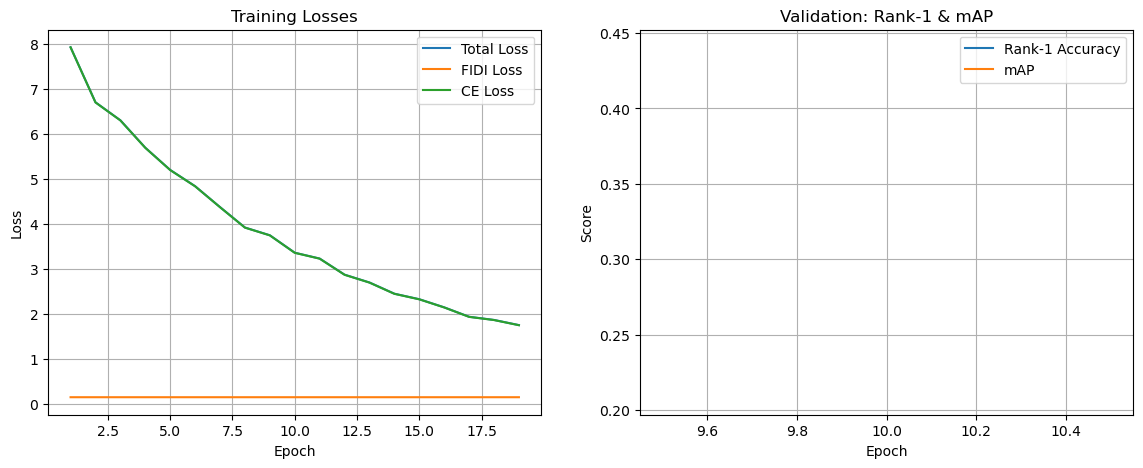


Epoch 20/250
--------------------------------------------------
Batch 0: Loss=1.8515, FIDI=0.1450×0.02, CE=1.8489×1.00


KeyboardInterrupt: 

In [ ]:
# =========================
# 9. Training Loop with Live Loss & Accuracy Plot
# =========================
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import sys
from datetime import datetime

# Set up logging to file
log_filename = f"training_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
log_file = open(log_filename, 'w')

# Create a custom print function that writes to both console and file
def log_print(*args, **kwargs):
    print(*args, **kwargs)
    print(*args, **kwargs, file=log_file)
    log_file.flush()  # Ensure immediate writing

# Redirect stdout to capture all print statements
original_stdout = sys.stdout
sys.stdout = log_file

# Log training start
log_print(f"Training started at: {datetime.now()}")
log_print(f"Using device: {device}")
log_print(f"FIDI parameters: alpha={alpha}, beta={beta}")
log_print(f"PK sampling: P={P}, K={K}, batch_size={P*K}")
log_print(f"Number of classes: {num_classes}")
log_print("="*80)

train_losses = []
fidi_losses = []
ce_losses = []
epochs = []
rank1s = []
maps = []
eval_epochs = []

print(f"Using device: {device}")
print(f"FIDI parameters: alpha={alpha}, beta={beta}")
print("Model and trainer initialized successfully!")
print("Starting training...")

num_epochs_to_run = num_epochs  # You can override this for shorter runs
eval_freq = 10  # You can set this in your config cell if you want

plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for epoch in range(num_epochs_to_run):
    log_print(f'\nEpoch {epoch+1}/{num_epochs_to_run}')
    log_print('-' * 50)
    avg_loss, avg_fidi_loss, avg_ce_loss = trainer.train_epoch(train_loader)
    train_losses.append(avg_loss)
    fidi_losses.append(avg_fidi_loss)
    ce_losses.append(avg_ce_loss)
    epochs.append(epoch + 1)

    # Evaluate and collect accuracy/mAP
    if (epoch + 1) % eval_freq == 0 or (epoch + 1) == num_epochs_to_run:
        log_print("Evaluating...")
        cmc, mAP = trainer.evaluate(query_loader, gallery_loader)
        rank1 = float(cmc[0].item())
        rank1s.append(rank1)
        maps.append(float(mAP))
        eval_epochs.append(epoch + 1)
        log_print(f'Rank-1: {rank1:.4f}, mAP: {mAP:.4f}')

    # Live plot
    clear_output(wait=True)
    ax1.clear()
    ax1.plot(epochs, train_losses, label='Total Loss')
    ax1.plot(epochs, fidi_losses, label='FIDI Loss')
    ax1.plot(epochs, ce_losses, label='CE Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Losses')
    ax1.legend()
    ax1.grid(True)

    ax2.clear()
    ax2.plot(eval_epochs, rank1s, label='Rank-1 Accuracy')
    ax2.plot(eval_epochs, maps, label='mAP')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Validation: Rank-1 & mAP')
    ax2.legend()
    ax2.grid(True)

    display(fig)
    plt.pause(0.01)

    trainer.scheduler.step()

    # Save TorchScript model every 5 epochs
    # Save both TorchScript (.pt) and PyTorch (.pth) models every 5 epochs
    if (epoch + 1) % 5 == 0:
        # Create weights directory if it doesn't exist
        os.makedirs("weights", exist_ok=True)
        
        # Save PyTorch state dict (.pth file)
        pth_path = f"weights/checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': trainer.model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
            'scheduler_state_dict': trainer.scheduler.state_dict()
        }, pth_path)
        
        # Save TorchScript model (.pt file) - also in weights folder
        model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model
        scripted = torch.jit.script(model_to_save)
        script_path = f"weights/checkpoint_epoch_{epoch+1}.pt"
        scripted.save(script_path)
        
        print(f"Models saved - PyTorch: {pth_path}, TorchScript: {script_path}")


plt.ioff()
plt.show()
print("Training completed.")